In [26]:
!unzip "dataset.zip" -d "dataset"

Streaming output truncated to the last 5000 lines.
  inflating: dataset/dataset/training_set/cats/cat.3700.jpg  
  inflating: dataset/dataset/training_set/cats/cat.3701.jpg  
  inflating: dataset/dataset/training_set/cats/cat.3702.jpg  
  inflating: dataset/dataset/training_set/cats/cat.3703.jpg  
  inflating: dataset/dataset/training_set/cats/cat.3704.jpg  
  inflating: dataset/dataset/training_set/cats/cat.3705.jpg  
  inflating: dataset/dataset/training_set/cats/cat.3706.jpg  
  inflating: dataset/dataset/training_set/cats/cat.3707.jpg  
  inflating: dataset/dataset/training_set/cats/cat.3708.jpg  
  inflating: dataset/dataset/training_set/cats/cat.3709.jpg  
  inflating: dataset/dataset/training_set/cats/cat.371.jpg  
  inflating: dataset/dataset/training_set/cats/cat.3710.jpg  
  inflating: dataset/dataset/training_set/cats/cat.3711.jpg  
  inflating: dataset/dataset/training_set/cats/cat.3712.jpg  
  inflating: dataset/dataset/training_set/cats/cat.3713.jpg  
  inflating: dataset

### CNN Model without using Transfer learning

In [28]:
# Importing the Keras libraries and packages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Convolution2D(32, 3, 3, input_shape = (64, 64, 3), activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Convolution2D(32, 3, 3, activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(128, activation = 'relu'))
classifier.add(Dense(1, activation = 'sigmoid'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Part 2 - Fitting the CNN to the images

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('dataset/dataset/training_set',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('dataset/dataset/test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

print(len(training_set))
print(len(test_set))

train_steps_per_epoch = len(training_set) // 32
val_steps_per_epoch = len(test_set) // 32

print(train_steps_per_epoch)
print(val_steps_per_epoch)

classifier.fit_generator(training_set,
                         steps_per_epoch=250,
                         validation_steps=63,
                         epochs= 10,
                         validation_data = test_set)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
250
63
7
1


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
250/250 [==============================] - 30s 118ms/step - loss: 0.6933 - accuracy: 0.5063 - val_loss: 0.6875 - val_accuracy: 0.5725
Epoch 2/10
250/250 [==============================] - 29s 118ms/step - loss: 0.6861 - accuracy: 0.5494 - val_loss: 0.6648 - val_accuracy: 0.6130
Epoch 3/10
250/250 [==============================] - 29s 117ms/step - loss: 0.6660 - accuracy: 0.5905 - val_loss: 0.6737 - val_accuracy: 0.5905
Epoch 4/10
250/250 [==============================] - 29s 118ms/step - loss: 0.6470 - accuracy: 0.6207 - val_loss: 0.6433 - val_accuracy: 0.6245
Epoch 5/10
250/250 [==============================] - 29s 118ms/step - loss: 0.6424 - accuracy: 0.6213 - val_loss: 0.6323 - val_accuracy: 0.6475
Epoch 6/10
250/250 [==============================] - 29s 117ms/step - loss: 0.6280 - accuracy: 0.6410 - val_loss: 0.6164 - val_accuracy: 0.6565
Epoch 7/10
250/250 [==============================] - 29s 117ms/step - loss: 0.6253 - accuracy: 0.6448 - val_loss: 0.6189 - val_ac

### Cat-Dog Classifier using Transfer Learning --- Local Dataset

In [29]:
from keras.layers import Input, Lambda, Dense, Flatten 
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as K
%matplotlib inline

### Add preprocessing layer to front of VGG

+[3] is added becuase of no of channels , Because we have images in RGB channel

+[1] if you have black and white images

We will use pretrained weights of VGG 16 which was trained on Imagenet dataset

If we set include_top=False means we will not add Last / output layer of VGG16

In [37]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'dataset/dataset/training_set'
valid_path = 'dataset/dataset/test_set'

# useful for getting number of classes
folders = glob('dataset/dataset/training_set/*')
folders
initializer = K.initializers.he_normal()

model = K.applications.VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


for layer in model.layers:
  layer.trainable = False
'''
# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)

### Appending of last layer with VGG16 
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()
'''

output = Flatten()(model.output)
layer_256 = K.layers.Dense(units=256,
                           activation='elu',
                           kernel_initializer=initializer,
                           kernel_regularizer=K.regularizers.l2())
output = layer_256(output)
dropout = K.layers.Dropout(0.5)
output = dropout(output)
softmax = K.layers.Dense(units=len(folders),
                         activation='softmax',
                         kernel_initializer=initializer,
                         kernel_regularizer=K.regularizers.l2())
output = softmax(output)
model = K.models.Model(inputs=model.input, outputs=output)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [38]:
model.compile(
         optimizer=K.optimizers.Adam(learning_rate=1e-4),
         loss='categorical_crossentropy',
         metrics=['accuracy'])

### Call back functions to be used while training 

# reduce learning rate when val_accuracy has stopped improving
lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                          factor=0.6,
                                          patience=2,
                                          verbose=1,
                                          mode='max',
                                          min_lr=1e-7)
# stop training when val_accuracy has stopped improving
early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                       patience=3,
                                       verbose=1,
                                       mode='max')
# callback to save the Keras model and (best) weights obtained on an epoch basis. here, the trained (compiled) model is saved in the current working directory as 'cifar10.h5'
checkpoint = K.callbacks.ModelCheckpoint('catdog_vgg19.h5',
                                         monitor='val_accuracy',
                                         verbose=1,
                                         save_weights_only=False,
                                         save_best_only=True,
                                         mode='max',
                                         save_freq='epoch')

### Data Augmentation and Training

In [39]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory('dataset/dataset/training_set',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('dataset/dataset/test_set',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

'''r=model.fit_generator(training_set,
                         samples_per_epoch = 8000,
                         nb_epoch = 5,
                         validation_data = test_set,
                         nb_val_samples = 2000)'''

print(len(training_set))
print(len(test_set))

train_steps_per_epoch = len(training_set) // 32
val_steps_per_epoch = len(test_set) // 32

print(train_steps_per_epoch)
print(val_steps_per_epoch)

# fit the model
history = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=250,
  validation_steps=63,
  callbacks=[lr_reduce, early_stop, checkpoint])

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
250
63
7
1


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
250/250 [==============================] - 112s 446ms/step - loss: 4.3668 - accuracy: 0.7577 - val_loss: 2.2357 - val_accuracy: 0.8560

Epoch 00001: val_accuracy improved from -inf to 0.85600, saving model to catdog_vgg19.h5
Epoch 2/10
250/250 [==============================] - 111s 442ms/step - loss: 2.0047 - accuracy: 0.8628 - val_loss: 1.4320 - val_accuracy: 0.9105

Epoch 00002: val_accuracy improved from 0.85600 to 0.91050, saving model to catdog_vgg19.h5
Epoch 3/10
250/250 [==============================] - 110s 441ms/step - loss: 1.3890 - accuracy: 0.8829 - val_loss: 1.1904 - val_accuracy: 0.8645

Epoch 00003: val_accuracy did not improve from 0.91050
Epoch 4/10
250/250 [==============================] - 111s 443ms/step - loss: 1.0837 - accuracy: 0.8915 - val_loss: 0.9086 - val_accuracy: 0.9070

Epoch 00004: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 00004: val_accuracy did not improve from 0.91050
Epoch 5/10
250/250 [====================

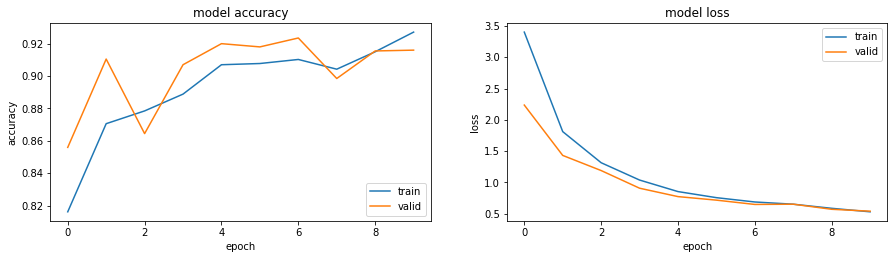

In [40]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

### RESNET 152 V2 Transfer Learning Model

In [41]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'dataset/dataset/training_set'
valid_path = 'dataset/dataset/test_set'

# useful for getting number of classes
folders = glob('dataset/dataset/training_set/*')
folders
initializer = K.initializers.he_normal()

model = K.applications.ResNet152V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


for layer in model.layers:
  layer.trainable = False
'''
# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)

### Appending of last layer with VGG16 
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()
'''

output = Flatten()(model.output)
layer_256 = K.layers.Dense(units=256,
                           activation='elu',
                           kernel_initializer=initializer,
                           kernel_regularizer=K.regularizers.l2())
output = layer_256(output)
dropout = K.layers.Dropout(0.5)
output = dropout(output)
softmax = K.layers.Dense(units=len(folders),
                         activation='softmax',
                         kernel_initializer=initializer,
                         kernel_regularizer=K.regularizers.l2())
output = softmax(output)
model = K.models.Model(inputs=model.input, outputs=output)

model.summary()

234553344/234545216 [==============================] - 1s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________

In [42]:
model.compile(
         optimizer=K.optimizers.Adam(learning_rate=1e-4),
         loss='categorical_crossentropy',
         metrics=['accuracy'])

### Call back functions to be used while training 

# reduce learning rate when val_accuracy has stopped improving
lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                          factor=0.6,
                                          patience=2,
                                          verbose=1,
                                          mode='max',
                                          min_lr=1e-7)
# stop training when val_accuracy has stopped improving
early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                       patience=3,
                                       verbose=1,
                                       mode='max')
# callback to save the Keras model and (best) weights obtained on an epoch basis. here, the trained (compiled) model is saved in the current working directory as 'cifar10.h5'
checkpoint = K.callbacks.ModelCheckpoint('catdog_RESNET152V2.h5',
                                         monitor='val_accuracy',
                                         verbose=1,
                                         save_weights_only=False,
                                         save_best_only=True,
                                         mode='max',
                                         save_freq='epoch')

In [43]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory('dataset/dataset/training_set',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('dataset/dataset/test_set',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

'''r=model.fit_generator(training_set,
                         samples_per_epoch = 8000,
                         nb_epoch = 5,
                         validation_data = test_set,
                         nb_val_samples = 2000)'''

print(len(training_set))
print(len(test_set))

train_steps_per_epoch = len(training_set) // 32
val_steps_per_epoch = len(test_set) // 32

# fit the model
history = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=250,
  validation_steps=63,
  callbacks=[lr_reduce, early_stop, checkpoint],
  verbose=1
)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
250
63


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
250/250 [==============================] - 134s 508ms/step - loss: 3.5498 - accuracy: 0.9533 - val_loss: 1.9214 - val_accuracy: 0.9830

Epoch 00001: val_accuracy improved from -inf to 0.98300, saving model to catdog_RESNET152V2.h5
Epoch 2/10
250/250 [==============================] - 125s 499ms/step - loss: 1.6932 - accuracy: 0.9863 - val_loss: 1.3894 - val_accuracy: 0.9815

Epoch 00002: val_accuracy did not improve from 0.98300
Epoch 3/10
250/250 [==============================] - 125s 498ms/step - loss: 1.2471 - accuracy: 0.9886 - val_loss: 1.0822 - val_accuracy: 0.9820

Epoch 00003: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 00003: val_accuracy did not improve from 0.98300
Epoch 4/10
250/250 [==============================] - 125s 500ms/step - loss: 0.9746 - accuracy: 0.9906 - val_loss: 0.9198 - val_accuracy: 0.9800

Epoch 00004: val_accuracy did not improve from 0.98300
Epoch 00004: early stopping


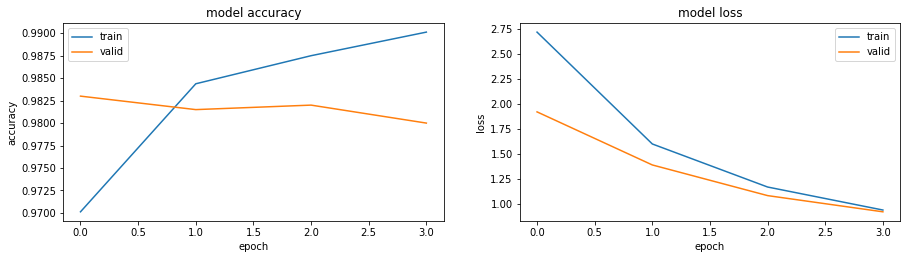

In [44]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

### Inception V3 - Transfer learning Model

In [45]:
# re-size all the images to this
IMAGE_SIZE = [299, 299]

train_path = 'dataset/dataset/training_set'
valid_path = 'dataset/dataset/test_set'

# useful for getting number of classes
folders = glob('dataset/dataset/training_set/*')
folders
initializer = K.initializers.he_normal()
model = K.applications.InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


for layer in model.layers:
  layer.trainable = False
'''
# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)

### Appending of last layer with VGG16 
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()
'''

output = Flatten()(model.output)
layer_256 = K.layers.Dense(units=256,
                           activation='elu',
                           kernel_initializer=initializer,
                           kernel_regularizer=K.regularizers.l2())
output = layer_256(output)
dropout = K.layers.Dropout(0.5)
output = dropout(output)
softmax = K.layers.Dense(units=len(folders),
                         activation='softmax',
                         kernel_initializer=initializer,
                         kernel_regularizer=K.regularizers.l2())
output = softmax(output)
model = K.models.Model(inputs=model.input, outputs=output)

model.summary()

87916544/87910968 [==============================] - 0s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 149, 149, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
___________________________

In [46]:
model.compile(
         optimizer=K.optimizers.Adam(learning_rate=1e-4),
         loss='categorical_crossentropy',
         metrics=['accuracy'])

### Call back functions to be used while training 

# reduce learning rate when val_accuracy has stopped improving
lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                          factor=0.6,
                                          patience=2,
                                          verbose=1,
                                          mode='max',
                                          min_lr=1e-7)
# stop training when val_accuracy has stopped improving
early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                       patience=3,
                                       verbose=1,
                                       mode='max')
# callback to save the Keras model and (best) weights obtained on an epoch basis. here, the trained (compiled) model is saved in the current working directory as 'cifar10.h5'
checkpoint = K.callbacks.ModelCheckpoint('catdog_InceptionV3.h5',
                                         monitor='val_accuracy',
                                         verbose=1,
                                         save_weights_only=False,
                                         save_best_only=True,
                                         mode='max',
                                         save_freq='epoch')

In [47]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory('dataset/dataset/training_set',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('dataset/dataset/test_set',
                                            target_size = (299, 299),
                                            batch_size = 32,
                                            class_mode = 'categorical')

'''r=model.fit_generator(training_set,
                         samples_per_epoch = 8000,
                         nb_epoch = 5,
                         validation_data = test_set,
                         nb_val_samples = 2000)'''

print(len(training_set))
print(len(test_set))

train_steps_per_epoch = len(training_set) // 32
val_steps_per_epoch = len(test_set) // 32

# fit the model
history = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=250,
  validation_steps=63,
  callbacks=[lr_reduce, early_stop, checkpoint],
  verbose=1
)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
250
63


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
250/250 [==============================] - 168s 656ms/step - loss: 4.3765 - accuracy: 0.9550 - val_loss: 2.0830 - val_accuracy: 0.9935

Epoch 00001: val_accuracy improved from -inf to 0.99350, saving model to catdog_InceptionV3.h5
Epoch 2/10
250/250 [==============================] - 162s 649ms/step - loss: 1.8096 - accuracy: 0.9876 - val_loss: 1.2137 - val_accuracy: 0.9910

Epoch 00002: val_accuracy did not improve from 0.99350
Epoch 3/10
250/250 [==============================] - 164s 657ms/step - loss: 1.1578 - accuracy: 0.9839 - val_loss: 0.8086 - val_accuracy: 0.9935

Epoch 00003: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 00003: val_accuracy did not improve from 0.99350
Epoch 4/10
250/250 [==============================] - 163s 651ms/step - loss: 0.7515 - accuracy: 0.9900 - val_loss: 0.6079 - val_accuracy: 0.9895

Epoch 00004: val_accuracy did not improve from 0.99350
Epoch 00004: early stopping


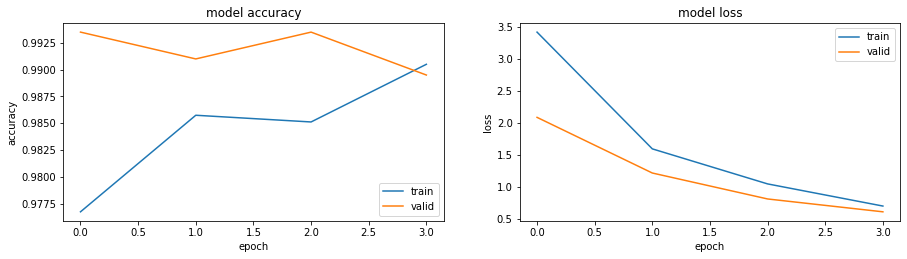

In [48]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

### Exception Transfer Learning Model

In [49]:
# re-size all the images to this
IMAGE_SIZE = [299, 299]

train_path = 'dataset/dataset/training_set'
valid_path = 'dataset/dataset/test_set'

# useful for getting number of classes
folders = glob('dataset/dataset/training_set/*')
folders
initializer = K.initializers.he_normal()
model = K.applications.Xception(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


for layer in model.layers:
  layer.trainable = False
'''
# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)

### Appending of last layer with VGG16 
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()
'''

output = Flatten()(model.output)
layer_256 = K.layers.Dense(units=256,
                           activation='elu',
                           kernel_initializer=initializer,
                           kernel_regularizer=K.regularizers.l2())
output = layer_256(output)
dropout = K.layers.Dropout(0.5)
output = dropout(output)
softmax = K.layers.Dense(units=len(folders),
                         activation='softmax',
                         kernel_initializer=initializer,
                         kernel_regularizer=K.regularizers.l2())
output = softmax(output)
model = K.models.Model(inputs=model.input, outputs=output)

model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________

In [50]:
model.compile(
         optimizer=K.optimizers.Adam(learning_rate=1e-4),
         loss='categorical_crossentropy',
         metrics=['accuracy'])

### Call back functions to be used while training 

# reduce learning rate when val_accuracy has stopped improving
lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                          factor=0.6,
                                          patience=2,
                                          verbose=1,
                                          mode='max',
                                          min_lr=1e-7)
# stop training when val_accuracy has stopped improving
early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                       patience=3,
                                       verbose=1,
                                       mode='max')
# callback to save the Keras model and (best) weights obtained on an epoch basis. here, the trained (compiled) model is saved in the current working directory as 'cifar10.h5'
checkpoint = K.callbacks.ModelCheckpoint('catdog_InceptionException.h5',
                                         monitor='val_accuracy',
                                         verbose=1,
                                         save_weights_only=False,
                                         save_best_only=True,
                                         mode='max',
                                         save_freq='epoch')

In [51]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory('dataset/dataset/training_set',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('dataset/dataset/test_set',
                                            target_size = (299, 299),
                                            batch_size = 32,
                                            class_mode = 'categorical')

'''r=model.fit_generator(training_set,
                         samples_per_epoch = 8000,
                         nb_epoch = 5,
                         validation_data = test_set,
                         nb_val_samples = 2000)'''

print(len(training_set))
print(len(test_set))

train_steps_per_epoch = len(training_set) // 32
val_steps_per_epoch = len(test_set) // 32

# fit the model
history = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=250,
  validation_steps=63,
  callbacks=[lr_reduce, early_stop, checkpoint],
  verbose=1
)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
250
63


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
250/250 [==============================] - 188s 741ms/step - loss: 3.0032 - accuracy: 0.9741 - val_loss: 0.9875 - val_accuracy: 0.9925

Epoch 00001: val_accuracy improved from -inf to 0.99250, saving model to catdog_InceptionException.h5
Epoch 2/10
250/250 [==============================] - 183s 732ms/step - loss: 0.8438 - accuracy: 0.9899 - val_loss: 0.6361 - val_accuracy: 0.9920

Epoch 00002: val_accuracy did not improve from 0.99250
Epoch 3/10
250/250 [==============================] - 182s 727ms/step - loss: 0.5528 - accuracy: 0.9908 - val_loss: 0.4854 - val_accuracy: 0.9920

Epoch 00003: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 00003: val_accuracy did not improve from 0.99250
Epoch 4/10
250/250 [==============================] - 182s 726ms/step - loss: 0.4087 - accuracy: 0.9922 - val_loss: 0.3275 - val_accuracy: 0.9950

Epoch 00004: val_accuracy improved from 0.99250 to 0.99500, saving model to catdog_InceptionException.h5
Epoch 5/10
250

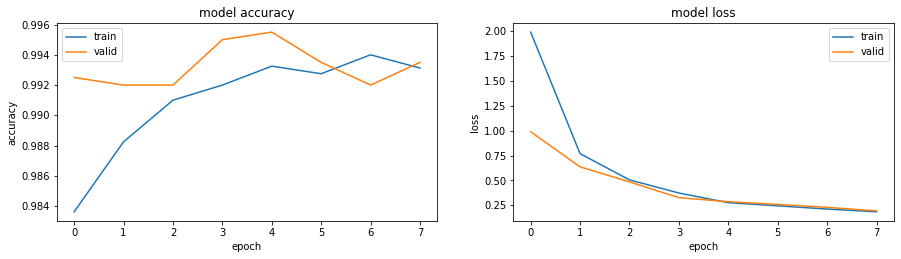

In [52]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()